# 🌐 Dynamic Graph Embeddings for Real-Time Anomaly Detection in Network Traffic

This notebook aims to design and implement a real-time anomaly detection system using dynamic graph embeddings. The model will be trained and evaluated on the KDD Cup 1999 dataset, which contains network traffic data.

## 1. Problem

Network intrusions and cyber-attacks pose significant threats to the security and functionality of systems. Real-time anomaly detection is essential to identify and possibly counteract these threats as they emerge. How can we detect anomalous patterns in network traffic efficiently in real-time?

## 2. Data

The data for this project is sourced from the KDD Cup 1999 dataset, which is widely acknowledged in the cybersecurity domain for intrusion detection tasks.

[Link to the Dataset](http://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html)

For computational feasibility, we'll be using the 10% subset of the dataset.

Files:
- `kddcup.names`: A list of features.
- `kddcup.data_10_percent.gz`: A 10% subset of the dataset.
- `kddcup.newtestdata_10_percent_unlabeled.gz`: Unlabeled 10% test data.
- `training_attack_types`: A list of intrusion types.
- `corrected.gz`: Test data with corrected labels.

## 3. Evaluation

The goal is to detect anomalies in network traffic. We will evaluate our model based on the following criteria:
- **Accuracy**: While a general metric, it gives an initial understanding of the model's performance.
- **Recall**: Essential to identify as many actual anomalies as possible.
- **Precision**: To ensure that the anomalies flagged are indeed anomalous and not false positives.
- **F1-score**: Harmonic mean of precision and recall.
- **ROC curve and AUC**: To evaluate the model's performance across different thresholds.

## 4. Features

Details about the dataset:

- The dataset contains multiple types of attacks, making this a multi-class classification problem.
- Features include basic features of individual TCP connections, content features within a connection, and traffic features computing using a two-second time window.
- Significant class imbalance exists, with many more normal connections than attacks, making it essential to consider techniques like resampling, using different evaluation metrics, or modifying model loss functions.
- We will transform the raw network traffic data into a dynamic graph representation where nodes could represent IP addresses, and edges could represent communication. As this graph evolves over time, we aim to capture these dynamics through embeddings for efficient anomaly detection.

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Setting for better visualization
sns.set_theme(style="whitegrid")
plt.style.use('seaborn-whitegrid')

/var/folders/r8/vs4vn7hx369dstqhq6gpmt980000gn/T/ipykernel_31969/1733646583.py:9: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


## 1. Data Preprocessing
### 1.1. Loading the Dataset
First, let's extract the column names from the kddcup.names file and then load the dataset.

In [2]:
# Extracting column names from kddcup.names
with open('data/kddcup.names', 'r') as f:
    lines = f.readlines()[1:]  # Skipping the first line
    columns = [line.split(':')[0] for line in lines]
columns.append('label')  # Adding the label column

# Load the dataset
data = pd.read_csv('data/kddcup.data.gz', header=None, names=columns)

# Display the first few rows of the dataset
data.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,http,SF,215,45076,0,0,0,0,...,0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,normal.
1,0,tcp,http,SF,162,4528,0,0,0,0,...,1,1.0,0.0,1.00,0.0,0.0,0.0,0.0,0.0,normal.
2,0,tcp,http,SF,236,1228,0,0,0,0,...,2,1.0,0.0,0.50,0.0,0.0,0.0,0.0,0.0,normal.
3,0,tcp,http,SF,233,2032,0,0,0,0,...,3,1.0,0.0,0.33,0.0,0.0,0.0,0.0,0.0,normal.
4,0,tcp,http,SF,239,486,0,0,0,0,...,4,1.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,normal.


In [4]:
# Check the basic statistics
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898431 entries, 0 to 4898430
Data columns (total 42 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   duration                     int64  
 1   protocol_type                object 
 2   service                      object 
 3   flag                         object 
 4   src_bytes                    int64  
 5   dst_bytes                    int64  
 6   land                         int64  
 7   wrong_fragment               int64  
 8   urgent                       int64  
 9   hot                          int64  
 10  num_failed_logins            int64  
 11  logged_in                    int64  
 12  num_compromised              int64  
 13  root_shell                   int64  
 14  su_attempted                 int64  
 15  num_root                     int64  
 16  num_file_creations           int64  
 17  num_shells                   int64  
 18  num_access_files             int64  
 19  

### 1.2. Exploratory Data Analysis
We'll start by visualizing the distribution of different classes (types of attacks) in the dataset.

/Users/akashmanujayaliyanaarachchi/Documents/UWE/CSCT Masters Project/Dynamic-Graph-Embeddings-for-Real-Time-Anomaly-Detection-in-Network-Traffic/venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/akashmanujayaliyanaarachchi/Documents/UWE/CSCT Masters Project/Dynamic-Graph-Embeddings-for-Real-Time-Anomaly-Detection-in-Network-Traffic/venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/akashmanujayaliyanaarachchi/Documents/UWE/CSCT Masters Project/Dynamic-Graph-Embeddings-for-Real-Time-Anomaly-Detection-in-Network-Traffic/venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWa

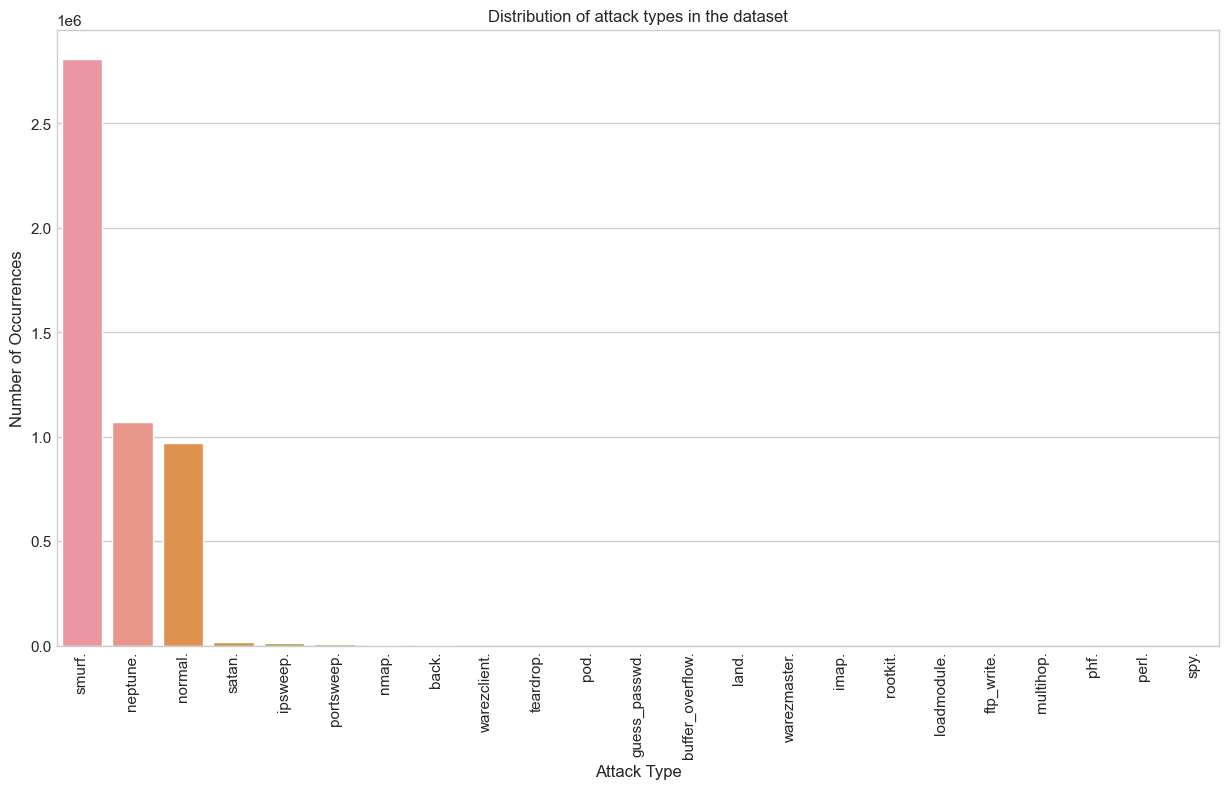

In [3]:
plt.figure(figsize=(15,8))
class_distribution = data['label'].value_counts()
sns.barplot(x=class_distribution.index, y=class_distribution.values)
plt.xticks(rotation=90)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Attack Type', fontsize=12)
plt.title('Distribution of attack types in the dataset')
plt.show();

### 1.3. Feature Exploration
Let's visualize the relationship between duration of connection and src_bytes.

/Users/akashmanujayaliyanaarachchi/Documents/UWE/CSCT Masters Project/Dynamic-Graph-Embeddings-for-Real-Time-Anomaly-Detection-in-Network-Traffic/venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/akashmanujayaliyanaarachchi/Documents/UWE/CSCT Masters Project/Dynamic-Graph-Embeddings-for-Real-Time-Anomaly-Detection-in-Network-Traffic/venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/akashmanujayaliyanaarachchi/Documents/UWE/CSCT Masters Project/Dynamic-Graph-Embeddings-for-Real-Time-Anomaly-Detection-in-Network-Traffic/venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWa

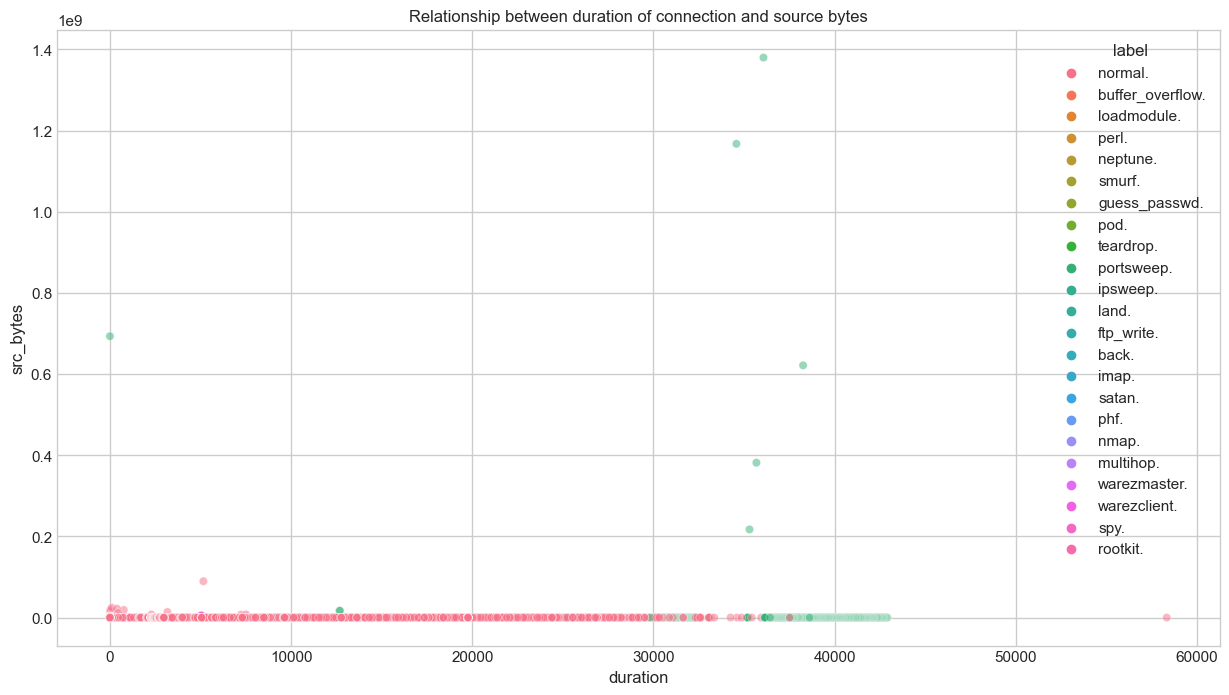

In [5]:
plt.figure(figsize=(15,8))
sns.scatterplot(data=data, x="duration", y="src_bytes", hue="label", alpha=0.5)
plt.title('Relationship between duration of connection and source bytes')
plt.show();

We can proceed with similar visual explorations for other features, based on preliminary findings and the relevance of the features to the task at hand.

### 1.4. Handling Missing Values
We'll handle any missing data, although the KDD Cup 1999 dataset is typically clean.

In [6]:
# Check for missing values
missing_values = data.isnull().sum()

# If there are any missing values, handle them. This is just a simple check.
if missing_values.any():
    # For this demonstration, we'll drop rows with missing values.
    # Depending on the nature and volume of missing data, you might choose imputation instead.
    data.dropna(inplace=True)

## 2. Feature Engineering and Preparing for Dynamic Graph Embeddings
### 2.1. Feature Transformation
Certain categorical features, such as protocol_type, service, and flag, need to be encoded to numerical types.

In [7]:
from sklearn.preprocessing import LabelEncoder

# Initialize label encoders
le_protocol = LabelEncoder()
le_service = LabelEncoder()
le_flag = LabelEncoder()

# Transform categorical columns
data['protocol_type'] = le_protocol.fit_transform(data['protocol_type'])
data['service'] = le_service.fit_transform(data['service'])
data['flag'] = le_flag.fit_transform(data['flag'])

### 2.2. Feature Selection for Graph Representation
For creating dynamic graphs, we must select features that can naturally represent nodes and edges. One approach is to consider source and destination IP addresses as nodes and the interactions between them as edges. However, in the KDD dataset, IP addresses are anonymized and not provided.

Instead, we can use the service column (which could denote different services or ports) as nodes and the interactions (records) between them as edges.

Let's proceed to create our graph.

### 2.3. Building the Graph
We'll use the networkx library to create and handle graphs. Here, we'll build a simple graph where nodes represent services and edges represent interactions between them. Each edge can have a weight indicating the number of interactions.

In [8]:
import networkx as nx

# Initialize graph
G = nx.Graph()

# Populate the graph
for index, row in data.iterrows():
    # Use 'service' as node. If node doesn't exist, it will be created.
    if row['service'] not in G:
        G.add_node(row['service'], label=row['service'])

    # Add or update edge
    if G.has_edge(row['service'], row['service']):
        # we added this one before, just increase the weight by one
        G[row['service']][row['service']]['weight'] += 1
    else:
        # new edge. add with weight=1
        G.add_edge(row['service'], row['service'], weight=1)

### 2.4. Visualization of the Graph
We can create a simple visualization of the graph to understand its structure.

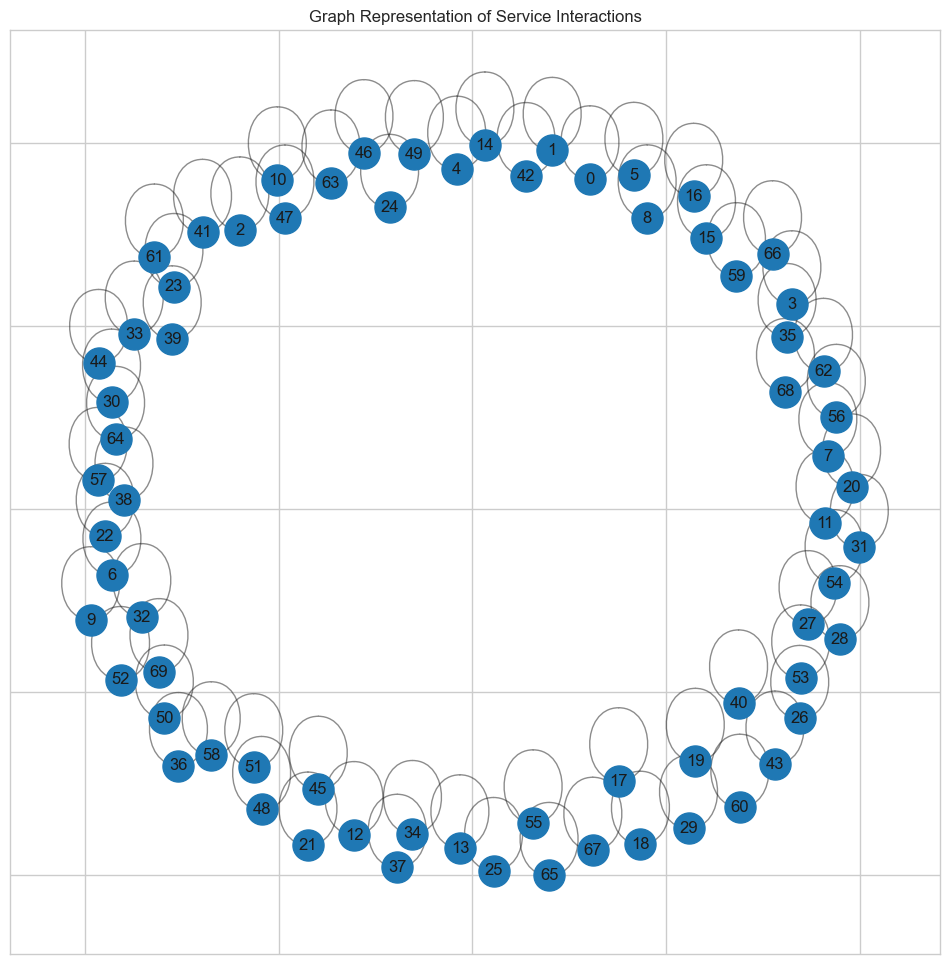

In [9]:
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G)  # positions for all nodes
nx.draw_networkx_nodes(G, pos, node_size=500)
nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5)
nx.draw_networkx_labels(G, pos, font_size=12)
plt.title("Graph Representation of Service Interactions")
plt.show()

## 3. Generating Dynamic Graph Embeddings
### 3.1. Statmic Graph Embeddings
Although the objective is to create dynamic graph embeddings, it's beneficial to understand the static context first.

Node2Vec is a popular method for generating node embeddings. We'll start with this.

In [10]:
from node2vec import Node2Vec

# Generate embeddings
node2vec = Node2Vec(G, dimensions=64, walk_length=30, num_walks=200, workers=4)
model = node2vec.fit(window=10, min_count=1)

# Retrieve node embeddings
node_embeddings = model.wv

Computing transition probabilities:   0%|          | 0/70 [00:00<?, ?it/s]

Generating walks (CPU: 3): 100%|██████████| 50/50 [00:00<00:00, 175.74it/s]


### 3.2. Transitioning to Dynamic Graph Embeddings
Dynamic graph embeddings account for the evolution of a graph over time. In the context of your data, one way to introduce a temporal dimension is by splitting the dataset into chunks based on timestamps (if available) or simply by ordered sequence.

This might look like:

Timestep 1: First 10% of data
Timestep 2: Next 10% of data
... and so on.
You'd then create graphs for each chunk and generate embeddings.

In [11]:
# Assuming we're using 10 timesteps
timesteps = 10
chunk_size = len(data) // timesteps

dynamic_embeddings = []

for t in range(timesteps):
    subset = data.iloc[t*chunk_size: (t+1)*chunk_size]

    # Create a graph for this subset similar to earlier
    G_t = nx.Graph()

    # Populate G_t from subset
    for index, row in subset.iterrows():
        if row['service'] not in G_t:
            G_t.add_node(row['service'], label=row['service'])

        if G_t.has_edge(row['service'], row['service']):
            G_t[row['service']][row['service']]['weight'] += 1
        else:
            G_t.add_edge(row['service'], row['service'], weight=1)

    # Check if the graph has nodes and edges before generating embeddings
    if len(G_t.nodes) > 0 and len(G_t.edges) > 0:
        node2vec = Node2Vec(G_t, dimensions=64, walk_length=30, num_walks=200, workers=4)
        model_t = node2vec.fit(window=10, min_count=1)
        dynamic_embeddings.append(model_t.wv)

Computing transition probabilities:   0%|          | 0/62 [00:00<?, ?it/s]

Generating walks (CPU: 3): 100%|██████████| 50/50 [00:00<00:00, 135.76it/s]


Computing transition probabilities:   0%|          | 0/66 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:00<00:00, 116.54it/s]


Computing transition probabilities:   0%|          | 0/68 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:00<00:00, 127.84it/s]


Computing transition probabilities:   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 3): 100%|██████████| 50/50 [00:00<00:00, 6362.91it/s]


Computing transition probabilities:   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:00<00:00, 10132.15it/s]


Computing transition probabilities:   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:00<00:00, 5854.21it/s]


Computing transition probabilities:   0%|          | 0/62 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:00<00:00, 149.86it/s]


Computing transition probabilities:   0%|          | 0/62 [00:00<?, ?it/s]

Generating walks (CPU: 3): 100%|██████████| 50/50 [00:00<00:00, 155.95it/s]


Computing transition probabilities:   0%|          | 0/40 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:00<00:00, 270.25it/s]


Computing transition probabilities:   0%|          | 0/64 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:00<00:00, 178.86it/s]


### 3.3. Preparing Data for Machine Learning
Once we have embeddings, we need to format our data for anomaly detection.

In [12]:
# Convert node embeddings to feature matrix
X = []
y = []

for index, row in data.iterrows():
    service = row['service']
    embedding = node_embeddings[service]
    X.append(embedding)
    y.append(row['label'])

X = np.array(X)
y = np.array(y)

### 3.4. Data Normalization
Normalization is crucial for distance-based models like KNN or clustering algorithms.

In [13]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## 4. Anomaly Detection using Machine Learning
### 4.1. Binarizing the Labels
For this project, the goal is to classify network traffic as either "normal" or "anomaly". Thus, we need to convert all various attack types into a single "anomaly" label.

In [14]:
# Convert all non-'normal.' labels to 'anomaly'
y_binarized = np.where(y == 'normal.', 'normal', 'anomaly')

### 4.2. Data Splitting
Split the dataset into training and testing sets using the binarized labels.

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train_bin, y_test_bin = train_test_split(X_scaled, y_binarized, test_size=0.2, random_state=42)

### 4.3. Handling Class Imbalance
Use BorderlineSMOTE to handle the class imbalance in the binarized labels.

In [16]:
from imblearn.over_sampling import BorderlineSMOTE

smote = BorderlineSMOTE()
X_train_smote, y_train_smote_bin = smote.fit_resample(X_train, y_train_bin)

### 4.4. Label Encoding
Convert the string labels ("normal" and "anomaly") to integers for efficient modeling.

In [17]:
from sklearn.preprocessing import LabelEncoder

# Initialize a label encoder
label_enc = LabelEncoder()

# Fit on the training set and transform both training and test sets
y_train_encoded = label_enc.fit_transform(y_train_smote_bin)
y_test_encoded = label_enc.transform(y_test_bin)

### 4.5. Model Selection
#### 4.5.1. Isolation Forest

In [18]:
from sklearn.ensemble import IsolationForest

# Train the model
clf = IsolationForest(contamination=0.05, random_state=42)
clf.fit(X_train_smote)

# Predict anomalies
y_pred_train = clf.predict(X_train_smote)
y_pred_test = clf.predict(X_test)

# Convert predictions for evaluation (IsolationForest labels anomalies as -1)
y_pred_train = np.where(y_pred_train == 1, 0, 1)
y_pred_test = np.where(y_pred_test == 1, 0, 1)

### 4.6. Model Evaluation
Evaluate the performance of our models.

In [19]:
from sklearn.metrics import classification_report, roc_auc_score

# Evaluation for Isolation Forest
print("Isolation Forest - Train:")
print(classification_report(y_train_encoded, y_pred_train))

print("\nIsolation Forest - Test:")
print(classification_report(y_test_encoded, y_pred_test))
print("ROC-AUC Score:", roc_auc_score(y_test_encoded, y_pred_test))

Isolation Forest - Train:
              precision    recall  f1-score   support

           0       0.52      0.99      0.69   3140652
           1       0.94      0.09      0.17   3140652

    accuracy                           0.54   6281304
   macro avg       0.73      0.54      0.43   6281304
weighted avg       0.73      0.54      0.43   6281304


Isolation Forest - Test:
              precision    recall  f1-score   support

           0       0.84      0.99      0.91    784998
           1       0.91      0.26      0.40    194689

    accuracy                           0.85    979687
   macro avg       0.88      0.63      0.66    979687
weighted avg       0.86      0.85      0.81    979687

ROC-AUC Score: 0.6259032366789947


# Model Evaluation

## 5. Hyperparameter Tuning for Isolation Forest:

We'll use GridSearchCV for a systematic search over specified parameter values. It uses cross-validation to determine which parameter value gives the best performance.

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define the grid of hyperparameters to search
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_samples': ['auto', 0.5, 0.75],
    'contamination': [0.01, 0.05, 0.1]
}

# Initialize GridSearchCV
grid_clf = GridSearchCV(IsolationForest(random_state=42), param_grid, scoring='f1', cv=3, n_jobs=-1)
grid_clf.fit(X_train_smote, y_train_encoded)

# Print the best parameters
print("Best parameters found: ", grid_clf.best_params_)

# Use the best model to make predictions
iso_forest_best = grid_clf.best_estimator_
y_pred_train = iso_forest_best.predict(X_train_smote)
y_pred_test = iso_forest_best.predict(X_test)

# Convert predictions for evaluation
y_pred_train = np.where(y_pred_train == 1, 0, 1)
y_pred_test = np.where(y_pred_test == 1, 0, 1)

## 6. Feature Selection:
### 6.1. Explanation:
By using a tree-based approach, we can determine feature importance scores. Features with low importance can be excluded, potentially enhancing the model's performance.



In [ ]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel

clf_fs = ExtraTreesClassifier(n_estimators=50)
clf_fs = clf_fs.fit(X_train_smote, y_train_encoded)

model = SelectFromModel(clf_fs, prefit=True)
X_train_new = model.transform(X_train_smote)
X_test_new = model.transform(X_test)

# Train Isolation Forest on selected features
iso_forest_fs = IsolationForest(contamination=0.05, random_state=42)
iso_forest_fs.fit(X_train_new)

y_pred_train = iso_forest_fs.predict(X_train_new)
y_pred_test = iso_forest_fs.predict(X_test_new)

# Convert predictions for evaluation
y_pred_train = np.where(y_pred_train == 1, 0, 1)
y_pred_test = np.where(y_pred_test == 1, 0, 1)

## 7. Adjust Anomaly Score Threshold:
### 7.1. Explanation:
Fine-tuning the decision threshold based on validation results can help us better control the precision-recall trade-off.

In [ ]:
# Get the decision function scores
train_scores = iso_forest_best.decision_function(X_train_smote)
test_scores = iso_forest_best.decision_function(X_test)

threshold = np.quantile(train_scores, 0.03)  # adjust the quantile value as needed

y_pred_train = [1 if score <= threshold else 0 for score in train_scores]
y_pred_test = [1 if score <= threshold else 0 for score in test_scores]

## 8. Model Evaluation:
### 8.1. Explanation:
Every time you make changes to your model, it's important to evaluate its performance to understand the effects of your modifications.

In [ ]:
from sklearn.metrics import classification_report, roc_auc_score

print("Isolation Forest - Train:")
print(classification_report(y_train_encoded, y_pred_train))

print("\nIsolation Forest - Test:")
print(classification_report(y_test_encoded, y_pred_test))
print("ROC-AUC Score:", roc_auc_score(y_test_encoded, y_pred_test))

As we can see from the above results, our base model gave best result among the other tuned models. so let's proceed with base model.

Visualizations can offer better insights into the model's performance and highlight areas of concern. Given that we're working on anomaly detection, some useful visualizations can include:

#### 1. Confusion Matrix:
The confusion matrix gives a clearer picture of where our model is making errors.

#### 2. ROC Curve and AUC:
The ROC curve provides a graphical representation of the true positive rate against the false positive rate. The AUC gives a single metric to compare models.



### 1. Confusion Matrix:

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute confusion matrix for Isolation Forest
cm = confusion_matrix(y_test_encoded, y_pred_test)

# Visualize the matrix
plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Isolation Forest')
plt.show()

### 2. ROC Curve:

In [ ]:
from sklearn.metrics import roc_curve

# Compute ROC curve for Isolation Forest
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred_test)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Isolation Forest')
plt.show()


## 6. Cross-Validation of the Model
### 6.1. Performing Stratified K-Fold Cross-Validation
The StratifiedKFold splits the data in a way that preserves the proportion of target labels in each fold. Given the imbalance and the categorical nature of our target variable, this approach is apt.

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score

n_splits = 5  # You can adjust this based on your computational capability
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
f1_scores = []

for train_index, test_index in skf.split(X_train_smote, y_train_encoded):
    X_train_fold, X_test_fold = X_train_smote[train_index], X_train_smote[test_index]
    y_train_fold, y_test_fold = y_train_encoded[train_index], y_train_encoded[test_index]

    # Train the model
    clf = IsolationForest(contamination=0.05, random_state=42)
    clf.fit(X_train_fold)

    # Predict anomalies
    y_pred_fold = clf.predict(X_test_fold)
    y_pred_fold = np.where(y_pred_fold == 1, 0, 1)  # Convert for evaluation

    f1 = f1_score(y_test_fold, y_pred_fold)
    f1_scores.append(f1)

mean_f1_score = np.mean(f1_scores)
print(f"Mean F1 Score across {n_splits} folds: {mean_f1_score}")

## 6. Random Forest Classifier Implementation
### 6.1. Introduction to Random Forest
Random Forest is an ensemble learning method. It operates by constructing multiple decision trees during training and outputs the mode of the classes (classification) of the individual trees for prediction.

Advantages:
Handling Higher Dimensionality: It can handle thousands of input variables without variable deletion.
Overfitting: The model runs efficiently on a large database and offers an effective method to estimate missing data. Overfitting is also not an issue.
### 6.2. Model Building
Let's start by building a basic Random Forest model on the training data.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Initialize the model
rf_model = RandomForestClassifier(random_state=42, n_jobs=-1)

# Train the model
rf_model.fit(X_train_smote, y_train_encoded)

### 6.3. Model Evaluation
Once the model is trained, we evaluate its performance on both the training and test datasets.

In [ ]:
# Predictions
y_pred_train_rf = rf_model.predict(X_train_smote)
y_pred_test_rf = rf_model.predict(X_test)

# Evaluation
print("Random Forest - Train:")
print(classification_report(y_train_encoded, y_pred_train_rf))

print("\nRandom Forest - Test:")
print(classification_report(y_test_encoded, y_pred_test_rf))
print("ROC-AUC Score:", roc_auc_score(y_test_encoded, y_pred_test_rf))

### 6.4. Feature Importance
One of the notable features of Random Forest is its ability to provide feature importance metrics. This helps in understanding which features are most influential in making predictions.

In [ ]:
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

# Plotting feature importances
plt.figure(figsize=(15, 7))
plt.title("Feature Importance")
plt.bar(range(X_train_smote.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train_smote.shape[1]), indices)
plt.xlim([-1, X_train_smote.shape[1]])
plt.show()

### 6.5. Hyperparameter Tuning

Just as with the Isolation Forest, the performance of the Random Forest classifier can often be improved with hyperparameter tuning. Here's a basic example using GridSearch:

In [ ]:
# Parameters for tuning
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Grid search
grid_rf = GridSearchCV(RandomForestClassifier(random_state=42, n_jobs=-1), param_grid, cv=3, scoring='f1', n_jobs=-1, verbose=2)
grid_rf.fit(X_train_smote, y_train_encoded)

# Best parameters
print("Best Parameters:", grid_rf.best_params_)

# Evaluating the best model
y_pred_test_grid = grid_rf.pred2ict(X_test)
print("\nRandom Forest (Tuned) - Test:")
print(classification_report(y_test_encoded, y_pred_test_grid))
print("ROC-AUC Score:", roc_auc_score(y_test_encoded, y_pred_test_grid))